# HW3: Hamiltonian Monte Carlo


**STATS271/371: Applied Bayesian Statistics**

_Stanford University. Winter, 2021._

---

**Name:** Isaac Kleisle-Murphy

**Names of any collaborators:** Yan, Anmol

*Due: 11:59pm Friday, April 23, 2021 via GradeScope*

---

In this homework assignment you'll perform MCMC with both Metropolis-Hastings Hamiltonian Monte Carlo. We will investigate the Federalist papers---specifically, modeling the rate at which Hamilton (we're using HMC after all!) uses the word _can_ in his papers. 

We will fit this model using a negative binomial distribution. That is, for each document $n$ that Hamilton wrote, we have the number of times the word 'can' appears $y_n$ as 
\begin{align}
y_n \sim \text{NB}(\mu_n, r)
\end{align}
where 
\begin{align}
\text{NB}(y_n \mid \mu_n, r) = \frac{\Gamma(y_n+r)}{\Gamma(r) \Gamma(y_n+1)} \left(\frac{r}{\mu_n + r}\right)^r \left(1 - \frac{r}{\mu_n + r}\right)^{y_n}
\end{align}
The mean is given by $\mathbb{E}[y_n] = \mu_n$, and $r$ controls the dispersion. Here, we model the mean for document $n$ as
\begin{align}
\mu_n = \frac{T_n}{1000} \mu
\end{align}
where $\mu$ is the rate of usage of 'can' per 1000 words and $T_n$ is the number of words in document $n$ (i.e. the document length).

For our model, we will use the following prior for the non-negative parameters,
\begin{align}
\log \mu &\sim \mathcal{N}(0, 9) \\
\log r &\sim \mathcal{N}(0, 9)
\end{align}

In a classic paper, Mosteller and Wallace (JASA, 1963) used likelihood ratios under negative binomial models with different mean rates for Alexander Hamilton and James Madison to infer the more likely author of disputed Federalist papers. Spoiler alert: while Hamilton wrote the majority of the papers, the 12 disputed papers appear to be Madison's! A key step in their analysis was estimating the NB parameters. While Mosteller and Wallace used a point estimate for each word and author, you'll do full posterior inference, focusing on Hamilton's use of the word _can_.


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Load the data
df = pd.read_csv('federalist_can_hamilton.csv').\
    drop(columns=['Unnamed: 0'])
Ts = np.array(df['Total'])
ys = np.array(df['N'])

df.head(10)

,X,Name,Total,word,N,Rate,Authorship,Disputed
0,65,Federalist No. 1,1622,can,3,0.001850,Hamilton,no
1,1526,Federalist No. 11,2511,can,5,0.001991,Hamilton,no
2,2437,Federalist No. 12,2171,can,2,0.000921,Hamilton,no
3,3125,Federalist No. 13,970,can,4,0.004124,Hamilton,no
4,4256,Federalist No. 15,3095,can,14,0.004523,Hamilton,no
5,5530,Federalist No. 16,2047,can,1,0.000489,Hamilton,no
6,6102,Federalist No. 17,1574,can,2,0.001271,Hamilton,no
7,9478,Federalist No. 21,2003,can,9,0.004493,Hamilton,no
8,10227,Federalist No. 22,3565,can,6,0.001683,Hamilton,no
9,11301,Federalist No. 23,1807,can,11,0.006087,Hamilton,no


## Problem 1  [math]: Show that the negative binomial can be expressed as the marginal distribution of a Poisson with gamma prior

Similar to how the Student's t distribution is a marginal of an inverse chi-squared and a Gaussian, show that

\begin{align}
\text{NB}(y \mid \mu, r) = \int \text{Po}(y \mid \lambda) \, \text{Ga}(\lambda \mid \alpha,\beta) \, \mathrm{d}\lambda
\end{align}

Express the parameters of the negative binomial distribution as a function of the parameters of the gamma distribution. (Assume $\beta$ is the rate parameter.)

We have
\begin{align*}
L(y| \alpha, \beta)
&\propto
\frac{\lambda^y\exp(\lambda)}{y!}\frac{\beta^\alpha \lambda^{\alpha - 1}\exp(-\beta\lambda)}{\Gamma(\alpha)} \\
&=
\frac{\beta^\alpha}{y! \Gamma(\alpha)} \lambda^{\alpha + y - 1} \exp(-\lambda(\beta + 1)).
\end{align*}
We identify a Gamma kernel here, hence, adding back in the scaling constants
\begin{align*}
\int_{\lambda} 
\frac{\beta^\alpha}{y! \Gamma(\alpha)} \lambda^{\alpha + y - 1} \exp(-\lambda(\beta + 1)) d\lambda
&=
\frac{\beta^\alpha}{y! \Gamma(\alpha)} \frac{\Gamma(y + \alpha)}{(\beta + 1)^{y + \alpha}} \\
&=
\frac{\Gamma(y + \alpha)}{y! \Gamma(\alpha)}\bigg(\frac{\beta}{\beta + 1}\bigg)^\alpha\bigg(\frac{1}{\beta + 1}\bigg)^y\\
&=
\frac{\Gamma(y + \alpha)}{y! (\alpha-1)!}\bigg(1 - \frac{1}{\beta + 1}\bigg)^\alpha\bigg(\frac{1}{\beta + 1}\bigg)^y \\
&=
\binom{y + \alpha - 1}{y}\bigg(1 - \frac{1}{\beta + 1}\bigg)^\alpha\bigg(\frac{1}{\beta + 1}\bigg)^y.
\end{align*}
This is a negative binomial p.m.f., as desired. We simply reparameterize to $\alpha = r, \frac{\beta}{\beta+1} = (1 - p) = \frac{r}{u_n + r}$ to get the complete result.

## Problem 2: Implement the log joint probability of the model

In [105]:
# import autograd.numpy as np
from scipy.special import gamma, loggamma, digamma
from scipy.stats import norm, nbinom, uniform
from tqdm import tqdm
import itertools

def log_density(yn, Tn, u, r):
    """
    Vectorized log density
    """
    un = Tn * u / 1000
    pn = r/(un + r) # note scipy flips em
    neg_binom = np.sum([nbinom.logpmf(yn[i], r, pn[i]) for i in range(len(yn))])
    prior_u = norm(0, 3).logpdf(np.log(u))
    prior_r = norm(0, 3).logpdf(np.log(r))
    # prior_u = norm(0, 3).pdf(u)
    # prior_r = norm(0, 3).pdf(r)
    return neg_binom + prior_u + prior_r

log_density(yn=df.N.values, Tn=df.Total.values, u=1, r=1) - \
    log_density(yn=df.N.values, Tn=df.Total.values, u=np.exp(1), r=np.exp(1))

-33.389341293153734

For the following MC implementation problems, sample in $\log(\mu), \log(r)$ space. Initialize with $\log(\mu) = 0, \log(r) = 0$.

## Problem 3: Implement Metropolis-Hastings

Implement and run Metropolis-Hastings with a spherical Gaussian proposal. Try various proposal variances.

In [121]:
from tqdm import tqdm

def metropolis_hastings(yn, Tn, niter=10000, sigma=1e-3):

    theta_log = np.zeros((niter + 1, 2))
    theta = theta_log[0, :]
    n_accept, n_reject = 0, 0

    for i in tqdm(range(niter)):
        theta_new = theta + norm(0, sigma).rvs(2)
        lik_old = log_density(yn, Tn, np.exp(theta[0]), np.exp(theta[1]))
        lik_new = log_density(yn, Tn, np.exp(theta_new[0]), np.exp(theta_new[1]))
        if np.log(uniform().rvs()) < lik_new - lik_old:
            theta_log[i + 1, :] = theta_new
            theta = theta_new
            n_accept += 1
        else:
            theta_log[i + 1, :] = theta
            n_reject += 1
            
#         pi = np.min([np.exp(lik_new - lik_old), 1])
#         urv = uniform(0, 1).rvs()
#         if pi == 1:
#             theta_log[i + 1, :] = theta_new
#             theta = theta_new
#             n_accept += 1
#         elif urv <= pi:
#             theta_log[i + 1, :] = theta_new
#             theta = theta_new
#             n_accept += 1
#         else:
#             theta_log[i + 1, :] = theta
#             n_reject += 1
    return dict(theta=theta_log, n_accept=n_accept, n_reject=n_reject)

mh_result = [metropolis_hastings(
    yn=df.N.values, 
    Tn=df.Total.values, 
    niter=10000, 
    sigma=i
    ) for i in [1, 1e-1, 1e-2, 1e-3]]

100%|██████████| 10000/10000 [03:55<00:00, 42.45it/s]


First, we plot diagnostics for proposal covariance $I$. The first plot is for $\mu$, the second for $r$ (this order persists throughout). We discard the first 1000 iterations, leaving us with 8,000 total draws. 

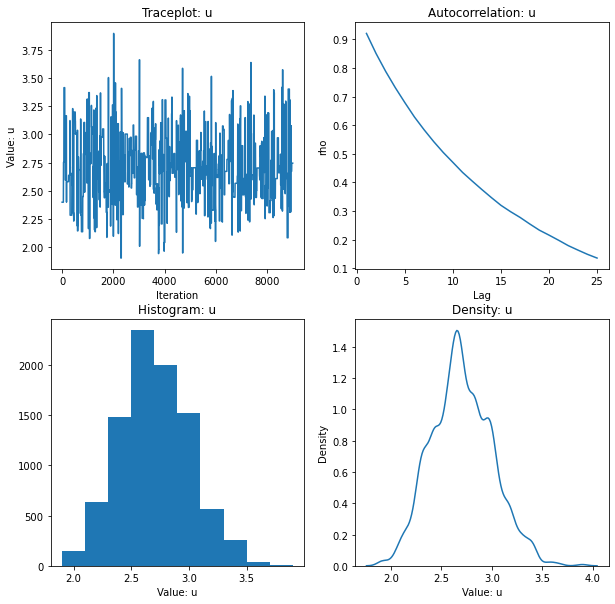

Effective Sample Size (u): 354.83793472017726


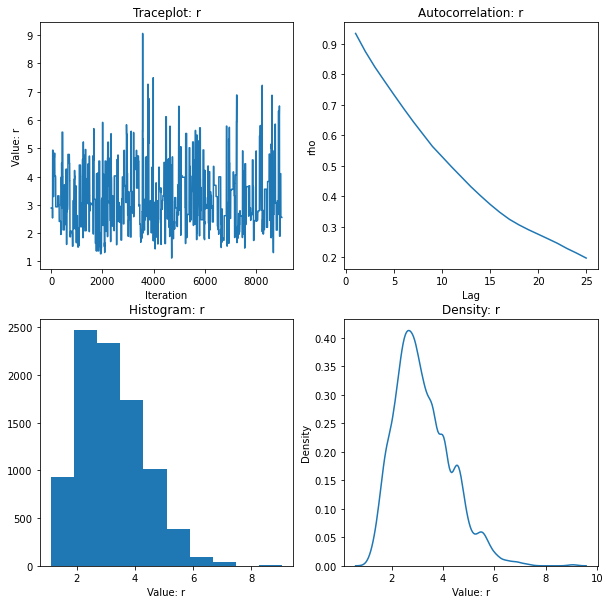

Effective Sample Size (r): 331.0623597633973


In [136]:
def compute_ess(x):
    """Effective sample size"""
    autocorr_all = [pearsonr(x[i:], x[:-i])[0] for i in range(1, int(len(x)/2))]
    switch=True
    ctr, pos_acf = 0, []
    while switch and ctr < len(autocorr_all):
        if autocorr_all[ctr] > 0:
            pos_acf.append(autocorr_all[ctr])
            ctr += 1
        else:
            switch=False
    return len(x)/(1 + 2 * np.sum(pos_acf))

def plot_diagnostics(x, burnin=0, transform=lambda x: x, varname=''):
    x_ = transform(x)
    x_ = x_[burnin:]
    auto_corr = [pearsonr(x_[i:], x_[:-i])[0] for i in range(1, 26)]

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    ax[0, 0].plot(x_)
    ax[0, 0].set_title(f'Traceplot: {varname}')
    ax[0, 0].set_xlabel('Iteration')
    ax[0, 0].set_ylabel(f'Value: {varname}')

    ax[0, 1].plot(range(1, 26), auto_corr)
    ax[0, 1].set_title(f'Autocorrelation: {varname}')
    ax[0, 1].set_xlabel('Lag')
    ax[0, 1].set_ylabel('rho')

    ax[1, 0].hist(x_)
    ax[1, 0].set_title(f'Histogram: {varname}')
    ax[1, 0].set_xlabel(f'Value: {varname}')

    sns.kdeplot(x=x_)
    ax[1, 1].set_title(f'Density: {varname}')
    ax[1, 1].set_xlabel(f'Value: {varname}')
    ax[1, 1].set_ylabel('Density')
    
    ess = compute_ess(x=x_)

    plt.show()
    print(f"Effective Sample Size ({varname}): {ess}")

plot_diagnostics(mh_result[0]['theta'][:, 0], 1000, np.exp, 'u')
plot_diagnostics(mh_result[0]['theta'][:, 1], 1000, np.exp, 'r')

Second, we plot diagnostics for proposal covariance $I/10$

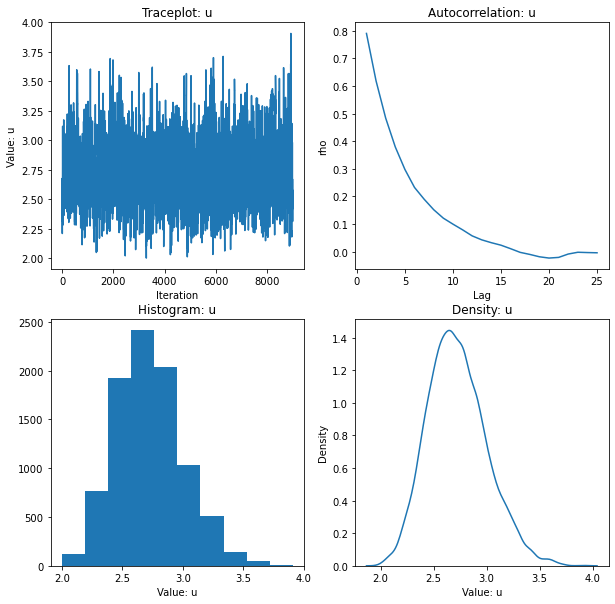

Effective Sample Size (u): 1093.995746861361


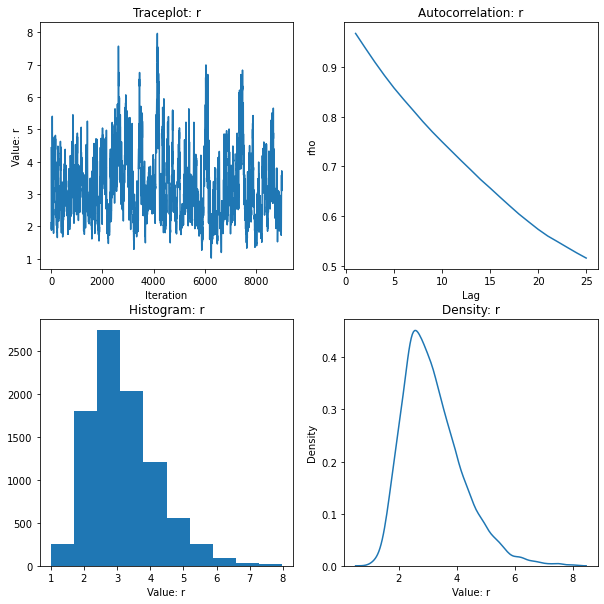

Effective Sample Size (r): 111.1082448106322


In [138]:
plot_diagnostics(mh_result[1]['theta'][:, 0], 1000, np.exp, 'u')
plot_diagnostics(mh_result[1]['theta'][:, 1], 1000, np.exp, 'r')

Third, we plot diagnostics for proposal covariance $I/100$

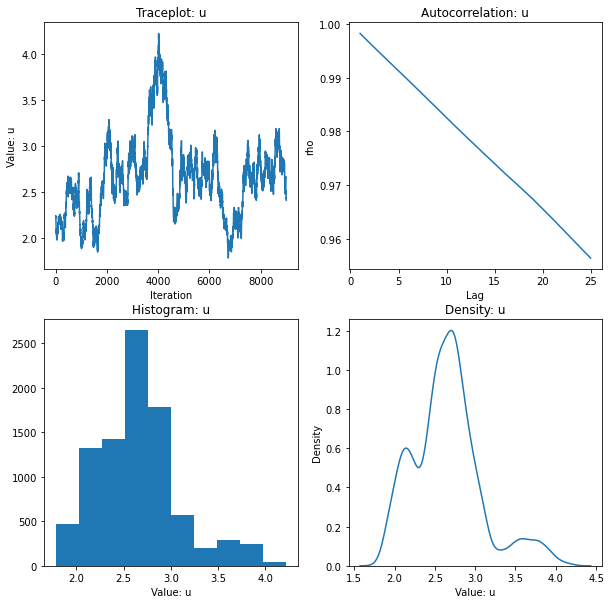

Effective Sample Size (u): 11.103457523171194


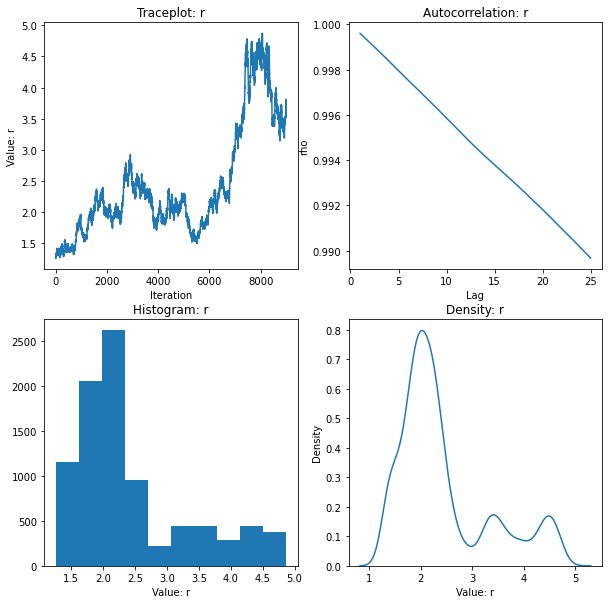

Effective Sample Size (r): 3.9251243991906954


In [139]:
plot_diagnostics(mh_result[2]['theta'][:, 0], 1000, np.exp, 'u')
plot_diagnostics(mh_result[2]['theta'][:, 1], 1000, np.exp, 'r')

Fourth, we plot diagnostics for proposal covariance $I/1000$

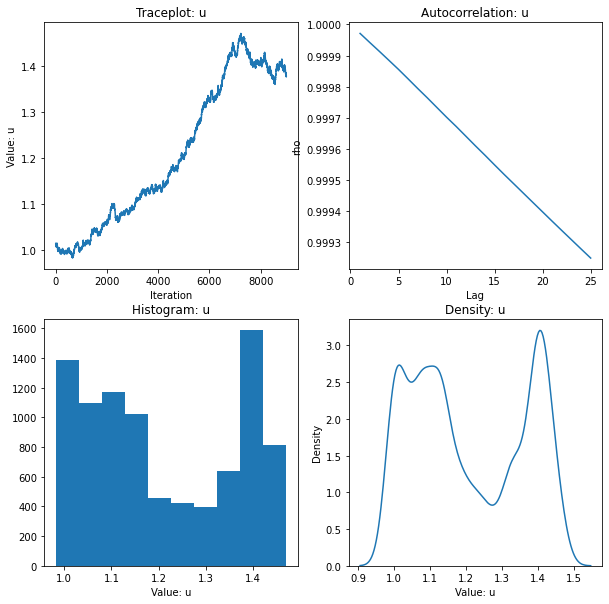

Effective Sample Size (u): 1.1276140982820202


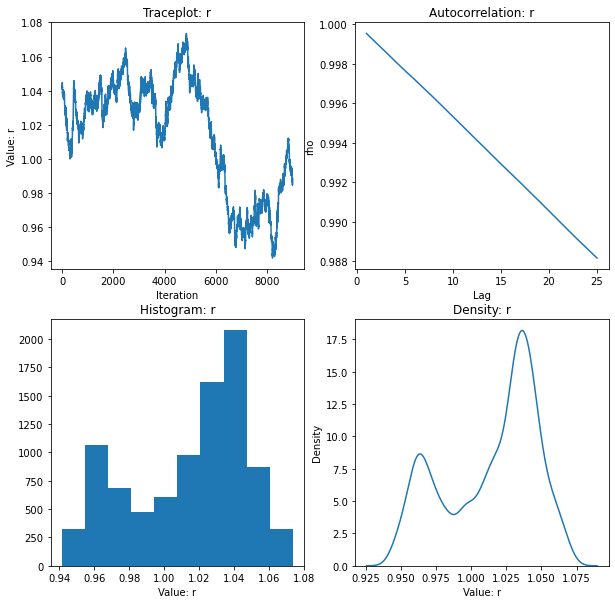

Effective Sample Size (r): 3.7049988933836486


In [141]:
plot_diagnostics(mh_result[3]['theta'][:, 0], 1000, np.exp, 'u')
plot_diagnostics(mh_result[3]['theta'][:, 1], 1000, np.exp, 'r')

## Problem 4: Implement Hamiltonian Monte Carlo

Implement the leapfrog step as a function, and run HMC. Try various step sizes and number of leapfrog steps.

Begin with log probability, and then sub $r^* = \log(r), \mu^* = \log(\mu)$:
\begin{align*}
\ell(\mu_i,\ r) 
&= 
\log \Big ( \prod_{i = 1}^n \frac{\Gamma(y_i+r)}{\Gamma(r) \Gamma(y_i+1)} \left(\frac{r}{\mu_i + r}\right)^r \left(1 - \frac{r}{\mu_i + r}\right)^{y_i} \frac{1}{\sqrt{(2 \pi)} \sigma} \exp(\frac{-1}{2 \sigma^2} (\log\mu)^2 \frac{1}{\sqrt{(2 \pi)} \sigma} \exp(\frac{-1}{2 \sigma^2} (\log r)^2)\Big)\\
&= \sum_{i=1}^n \log \Big(\frac{\Gamma(y_i+r)}{\Gamma(r) \Gamma(y_i+1)} \left(\frac{r}{\mu_i + r}\right)^r \left(\frac{\mu_i}{\mu_i + r}\right)^{y_i} \frac{1}{\sqrt{(2 \pi)} \sigma} \exp(\frac{-1}{2 \sigma^2} (\log\mu)^2 )\frac{1}{\sqrt{(2 \pi)} \sigma} \exp(\frac{-1}{2 \sigma^2} (\log r)^2))\Big) \\
&=
\bigg(\sum_{i=1}^n \log(\Gamma(y_i + r)) - \log(\Gamma(r)) - \log(\Gamma(y_i + 1)) + r\log r - (r + y_i)\log(\mu_i + r) + y_i \log(\mu_i)\bigg) + \\ &\hspace{2cm} \frac{-1}{2\sigma^2}\log^2\mu + \frac{-1}{2\sigma^2}\log^2r + C \\
&=
\bigg(\sum_{i=1}^n \log(\Gamma(y_i + \exp(r^*))) - \log(\Gamma(\exp(r^*))) - \\
&\hspace{3cm}\log(\Gamma(y_i + 1)) + \exp(r^*)r^* - (\exp(r^*) + y_i)\log(\frac{T_i}{1000}exp(\mu^*) + \exp(r^*)) + \\
& \;\;\;\;\;\;\;\;\;y_i \log(\frac{T_i}{1000}exp(\mu^*))\bigg) + \frac{-1}{2\sigma^2}(r^{*2} + \mu^{*2}).
\end{align*}
We then have, with repeated application of the chain rule
\begin{align*}
\frac{d\ell}{dr^*} \ell(\mu_i,\ r)
&=
\bigg(\sum 
\exp(r^*)\omega(y_i + \exp(r^*))
- \exp(r^*)\omega(\exp(r^*))
+ \exp(r^*)(1 + r^*)
 - \frac{(\exp(r^*) + y_i)}{\mu_i + \exp(r^*)} \\
 &\hspace{3cm}
 - \exp(r^*)\log(\mu_i + \exp(r^*))\bigg)
 - \frac{1}{\sigma^2}r^*.
\end{align*}
and 
\begin{align*}
\frac{d\ell}{d\mu^*} \ell(\mu_i,\ r)
&=
\bigg(\sum y_i - \frac{(\exp(r^*) + y_i)}{\frac{T_i}{1000}\exp(\mu^*) + \exp(r^*)}\frac{T_i}{1000}exp(\mu^*)\bigg) 
- \frac{1}{\sigma^2}\mu^*.
\end{align*}
The gradients here will be used during the leapfrog integration step, during HMC. 

In [99]:
def grad(yn, Tn, u_, r_, negative=True):
    """
    u_ is log(u); r_ is log(r)
    """
    # gradient of log(r) for the negative binomial part
    grad_r_binom = np.sum([
        np.exp(r_) * digamma(yn[i] + np.exp(r_))\
            - np.exp(r_) * digamma(np.exp(r_))\
            + np.exp(r_) * (1 + r_)\
            - np.exp(r_) * (np.exp(r_) + yn[i])/(Tn[i]/1000 * np.exp(u_) + np.exp(r_))\
            - np.exp(r_) * np.log(Tn[i]/1000 * np.exp(u_) + np.exp(r_))
        for i in range(len(yn))
    ])

    grad_u_binom = np.sum([
        yn[i] - (np.exp(r_) + yn[i])/(Tn[i]/1000 * np.exp(u_) + np.exp(r_)) * Tn[i]/1000 * np.exp(u_)
        for i in range(len(yn))
    ])

    grad_r_prior = -r_/9
    grad_u_prior = -u_/9
    result = np.array([grad_u_binom + grad_u_prior, grad_r_binom + grad_r_prior])
                       
    if negative:
        return -result
    return result

def leapfrog(p, u, r, yn, Tn, n_iter, eta):
    theta = np.array([np.copy(u), np.copy(r)])
    for step in range(n_iter):
        p = p - (eta * grad(yn, Tn, theta[0], theta[1]))/2
        # take an entire step of parameters
        theta = theta + (eta * p)
        # take an entire step of auxiliary
        p = p - (eta * grad(yn, Tn, theta[0], theta[1]))/2

    # momentum flip at end
    return theta, -p

# a couple test values
grad(df.N.values, df.Total.values, 0, 0)
leapfrog(p=np.array([0, 0]), u=0, r=0, yn=df.N.values, Tn=df.Total.values, n_iter=10, eta=.01)

(array([ 0.26688103, -0.01587039]), array([-5.01519291,  0.15589943]))

In [106]:
def hamilton_monte_carlo(yn, Tn, eta=.01, ham_steps=10, n_iter=10000, u_init=0, r_init=0):
    """"""
    theta = [u_init, r_init]
    theta_log = [theta]
    for _ in tqdm(range(n_iter)):
        p_before = norm(0, 1).rvs(2)
        theta_prop, p_prop = leapfrog(p_before, theta[0], theta[1], yn, Tn, n_iter=ham_steps, eta=eta)
        H_before =  -log_density(yn, Tn, np.exp(theta[0]), np.exp(theta[1]))\
            + p_before.dot(p_before)/2
        H_after =  -log_density(yn, Tn, np.exp(theta_prop[0]), np.exp(theta_prop[1]))\
            + p_prop.dot(p_prop)/2
        log_metropolis_ratio = H_before - H_after
        if np.log(uniform().rvs()) < log_metropolis_ratio:
            theta_log.append(theta_prop)
            theta = theta_prop
        else:
            theta_log.append(theta)
    theta_log = np.array(theta_log) 
    return theta_log

hmc_results = [hamilton_monte_carlo(yn, Tn, eta=eta, ham_steps=nstep, n_iter=10000)
               for nstep, eta in itertools.product([10, 50], [.1, .01])]

100%|██████████| 10000/10000 [40:21<00:00,  4.13it/s] 


For our first example, with 10 steps and step size 1/10 (burnin remains 1000):

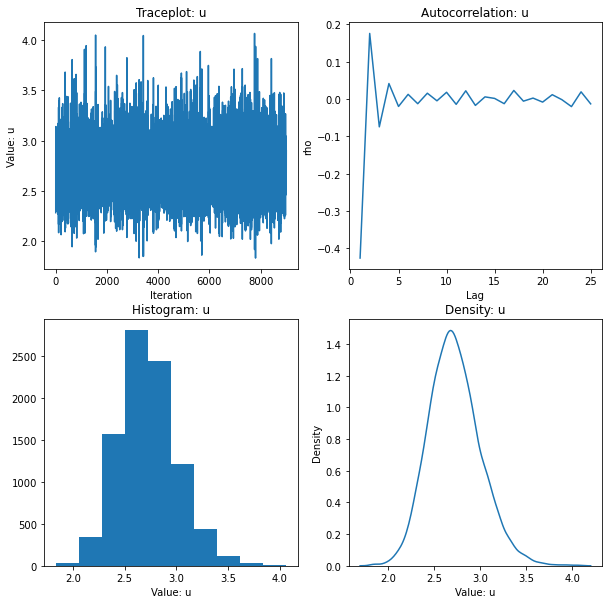

Effective Sample Size (u): 9001.0


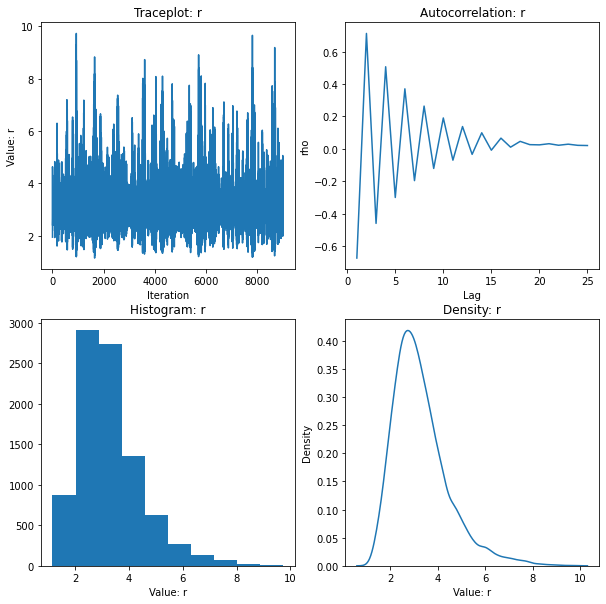

Effective Sample Size (r): 9001.0


In [142]:
plot_diagnostics(hmc_results[0][:, 0], 1000, np.exp, 'u')
plot_diagnostics(hmc_results[0][:, 1], 1000, np.exp, 'r')

Note that the initially negative autocorrelation breaks the ESS code. I'm not sure what the procedure here should be -- particularly in light of the ACF oscillations above. 

For our second example, with 10 steps and step size 1/100:

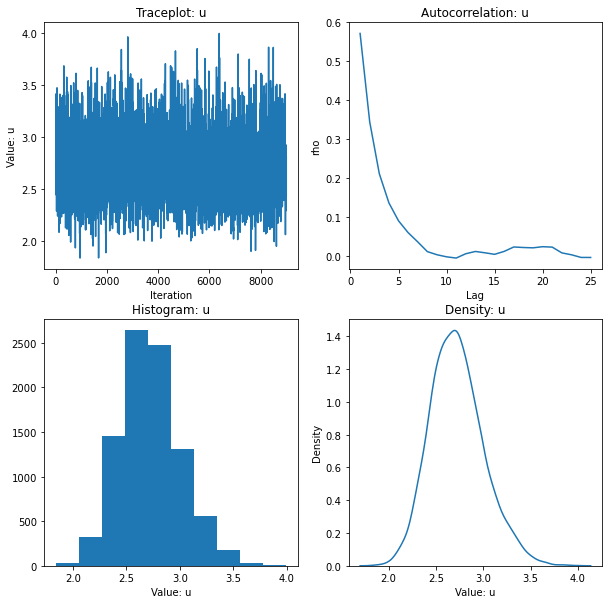

Effective Sample Size (u): 2298.833582011255


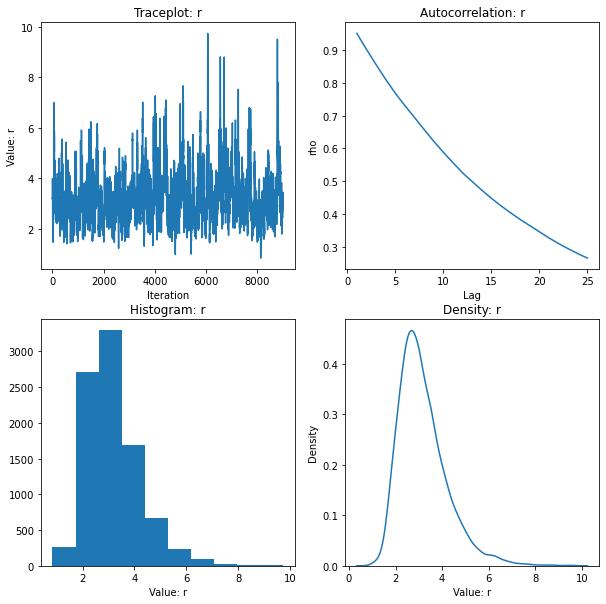

Effective Sample Size (r): 247.02347241860787


In [145]:
plot_diagnostics(hmc_results[1][:, 0], 1000, np.exp, 'u')
plot_diagnostics(hmc_results[1][:, 1], 1000, np.exp, 'r')

For our third example, with 50 steps and step size 1/10:

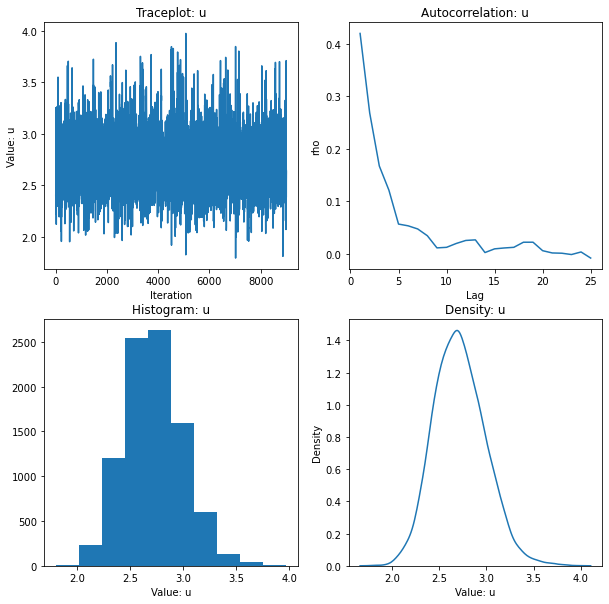

Effective Sample Size (u): 2421.445823735267


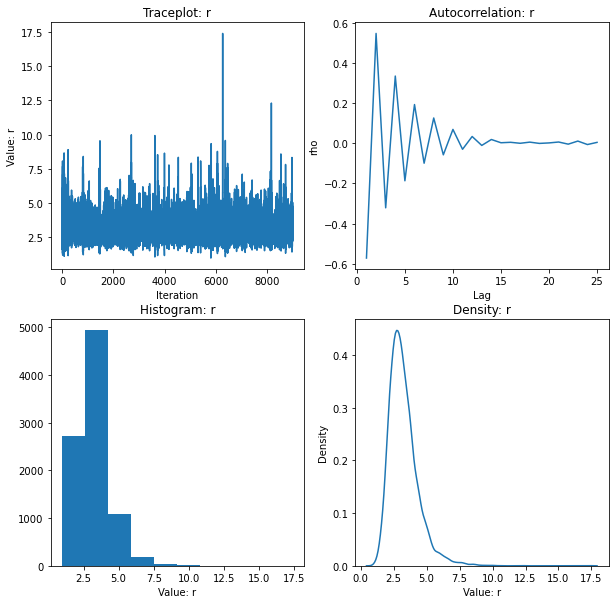

Effective Sample Size (r): 9001.0


In [146]:
plot_diagnostics(hmc_results[2][:, 0], 1000, np.exp, 'u')
plot_diagnostics(hmc_results[2][:, 1], 1000, np.exp, 'r')

Finally, for our fourth example, with 50 steps and step size 1/100:
    

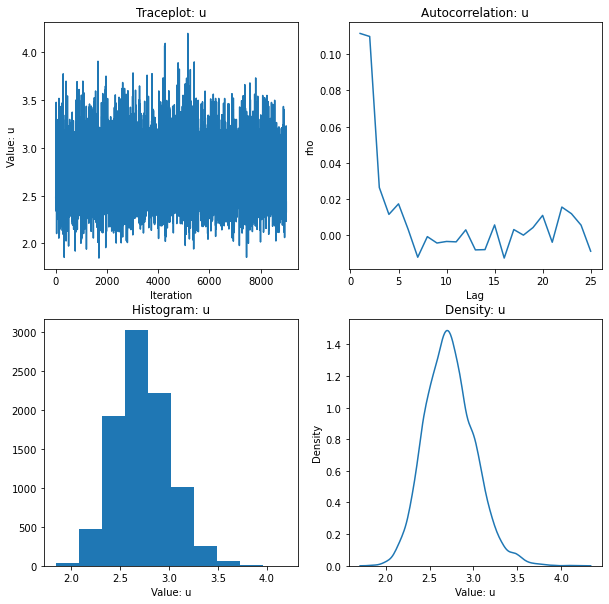

Effective Sample Size (u): 5772.7563567493935


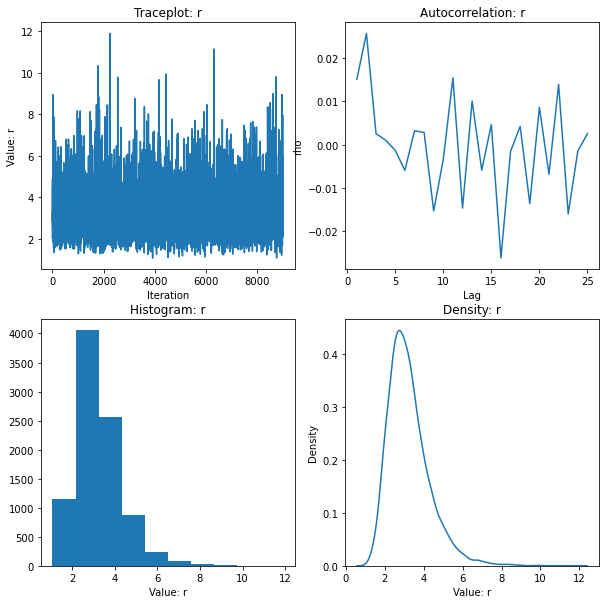

Effective Sample Size (r): 8268.678444712787


In [148]:
plot_diagnostics(hmc_results[3][:, 0], 1000, np.exp, 'u')
plot_diagnostics(hmc_results[3][:, 1], 1000, np.exp, 'r')

By the looks of things, this last setup appeared to be most convergent. 

## Problem 5: Diagnostics

For both algorithms, make trace plots of the parameters and plot histograms of posterior marginals.

In [149]:
# see above!

## Problem 6: Effective Sample Size

Calculate effective sample size for both chains.

In [150]:
# see above!

# Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF:
```
jupyter nbconvert --to pdf hw3_yourname.ipynb
```

**Dependencies:**

- `nbconvert`: If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .ipynb and .pdf files to Gradescope. 
